<a href="https://colab.research.google.com/github/tzhsu211/CVS/blob/Training0123/Training_0124.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PTT CVS Product Review Analysis

This project demonstrates a system for predicting product ratings based on reviews from PTT's CVS board using machine learning, specifically fine-tuning a pre-trained model. The tokenizer model used in this project is 'bert-base-chinese' and the pre-trained model is 'ckiplab/albert-tiny-chinese-ws', a variant of ALBERT for Traditional Chinese text.

In [1]:
pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 15.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
import torch
from transformers import BertTokenizerFast, AutoModelForSequenceClassification, Trainer, TrainingArguments, AutoConfig, EarlyStoppingCallback
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import random
from sklearn.model_selection import train_test_split
import torch.backends
import warnings
from datasets import Dataset
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
torch.cuda.is_available()

True

In [4]:
warnings.filterwarnings('ignore')

## Data Loading and Exploration
Load the data and explore its structure to ensure there are no errors or anomalies. Check the rating column's range, distribution, and other statistical details.

1. **Load the Data**: Import the CSV file and display the first few rows.
2. **Describe the Data**: Use `describe()` to get basic statistical information about the dataset.
3. **Check Rating Range**: Ensure that all ratings are within a valid range (0 to 100).
4. **View Rating Distribution**: Check the distribution of ratings and calculate the average rating for each store.
5. **Decide Max len**: The 80th percentile is 249 characters, which means a max_len of 256 would capture 80% of the reviews while truncating the longest 20%.

In [5]:
df = pd.read_csv('./cvs_products.csv')

In [6]:
df.head()

,product,link,store,CVS,rating,review
0,辻利抹茶歐蕾 38,https://www.ptt.cc/bbs/CVS/M.1570449843.A.7FF....,全家,全家,30,難喝.. 喝起來沒有抹茶味 只有一股很噁的甜味和水味 為了確認又喝幾口 真的難喝 大家就避開...
1,香辣霸王雞球/原價39元（友善價28元）,https://www.ptt.cc/bbs/CVS/M.1570452664.A.B42....,全家,全家,60,基本上在便利商店買這個就是解嘴饞 （因為要吃的鹹酥雞都沒開...） 然後一如其它炸物 微波後...
2,黑松C&C氣泡飲(王林蘋果風味) / 原價$29 全家購入特價$22,https://www.ptt.cc/bbs/CVS/M.1570461438.A.947....,全家 / 黑松,全家,90,最近好多蘋果氣泡飲料喔 看到綠色瓶身很漂亮，又有嚐鮮價 立刻忍不住試試XD 和其他蘋果汽水比...
3,美少女戰士悠遊閃卡-戰士款/100元,https://www.ptt.cc/bbs/CVS/M.1570494716.A.C35....,7-11 / 悠遊卡股份有限公司,7-11,100,第一彈其實完全沒有follow到， 偶然在板上看到第二彈情報文，結果覺得更生火！ 身為兒時禮...
4,統一麵包紫薯QQ 35,https://www.ptt.cc/bbs/CVS/M.1570502732.A.406....,7-11 統一麵包,7-11,88,早上到小七挑早餐看到紫薯覺得很特別就買來吃吃看 麵包整個顏色偏紫 味道聞起來甜甜 有淡淡的紫...


In [7]:
df['rating'].unique() # check all rating are valid int from 0 to 100

array([ 30,  60,  90, 100,  88,  68,  95,  75,  85,  80,  70,  40,  98,
        86,  65,  79,  59,  39,  89,  55,  49,  66,  83,  92,  84,  58,
         3,  50,  87,  78,  15,  99,  61,  72,  20,  81,  82,  93,   0,
        73,  10,  56,   7,  96,  74,  67,   8,  63,  76,   1,  69,  45,
         5,  77,  33,  62,  48,  94,  19,  42,  35,  25,  29,  91,  23,
        11,  32,  64,  71,  43,  31,   2,  97,  28])

In [8]:
average_ratings = df.groupby('CVS')['rating'].mean()
print(average_ratings)

CVS
7-11    75.067762
OK      74.958042
全家      76.982945
萊爾富     76.654160
Name: rating, dtype: float64


In [9]:
review_len = df['review'].str.len()
print(review_len.describe())

count    9618.000000
mean      183.482013
std       111.754112
min         1.000000
25%       109.000000
50%       161.000000
75%       228.750000
max      1582.000000
Name: review, dtype: float64


In [11]:
quantiles = [i / 10 for i in range(1, 10)]
quantile_values = review_len.quantile(quantiles)
print(quantile_values)

0.1     76.0
0.2     99.0
0.3    121.0
0.4    140.0
0.5    161.0
0.6    184.0
0.7    211.0
0.8    249.0
0.9    313.0
Name: review, dtype: float64


## Data Cleaning and Preprocessing
Clean the data by removing unnecessary columns and standardizing the ratings to make the data suitable for model training.

1. **Data Cleaning**: Remove columns that are not needed for the model (keep only `review` and `rating`).
2. **Standardization**: Standardize the rating column to ensure it is scaled appropriately for regression models.
3. **Train-Test Split**: Split the data into training (90%) and testing (10%) sets for model training and evaluation.

In [12]:
df1 = df.drop(['product', 'store', 'link', 'CVS'], axis = 1)

In [13]:
scaler = StandardScaler()
df1['rating_standard'] = scaler.fit_transform(df['rating'].values.reshape(-1, 1))

In [14]:
df1.head()

,rating,review,rating_standard
0,30,難喝.. 喝起來沒有抹茶味 只有一股很噁的甜味和水味 為了確認又喝幾口 真的難喝 大家就避開...,-2.862466
1,60,基本上在便利商店買這個就是解嘴饞 （因為要吃的鹹酥雞都沒開...） 然後一如其它炸物 微波後...,-1.005854
2,90,最近好多蘋果氣泡飲料喔 看到綠色瓶身很漂亮，又有嚐鮮價 立刻忍不住試試XD 和其他蘋果汽水比...,0.850757
3,100,第一彈其實完全沒有follow到， 偶然在板上看到第二彈情報文，結果覺得更生火！ 身為兒時禮...,1.469628
4,88,早上到小七挑早餐看到紫薯覺得很特別就買來吃吃看 麵包整個顏色偏紫 味道聞起來甜甜 有淡淡的紫...,0.726983


In [15]:
X_train, X_test, y_train, y_test = train_test_split(df1['review'], df1['rating_standard'], test_size=0.1, random_state=42)

In [16]:
train_df = pd.DataFrame({'text': X_train, 'label': y_train.astype(float)})
test_df = pd.DataFrame({'text': X_test, 'label': y_test.astype(float)})

train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

## Model Building and Training
Set up and initialize the model, and train it using the Hugging Face Transformers library.

1. **Model Selection and Initialization**: Use the pre-trained `bert-base-chinese` tokenizer and the `albert-tiny-chinese-ws` model to process the Chinese reviews.
2. **Model Structure Adjustment**: Since this is a regression task, we will modify the model's final layer to be a linear layer for regression.
3. **Training and Evaluation**: Set up training arguments, train the model, and evaluate its performance.

In [17]:
def preprocess_function(examples, tokenizer):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=256)

In [18]:
def compute_metrics(p):
    preds, labels = p
    preds = preds.squeeze()
    mse = mean_squared_error(labels, preds)
    r2 = r2_score(labels, preds)
    return {"mse": mse, "r2": r2}

In [19]:
def train_model(model, tokenizer_model, model_name, train_dataset = train_dataset, test_dataset = test_dataset, num_train_epochs=10, batch_size=32):

    tokenizer = BertTokenizerFast.from_pretrained(tokenizer_model)

    train_dataset = train_dataset.map(lambda x: preprocess_function(x, tokenizer), batched=True)
    test_dataset = test_dataset.map(lambda x: preprocess_function(x, tokenizer), batched=True)

    # 設定 TrainingArguments
    training_args = TrainingArguments(
        output_dir=f'./results/{model_name}',
        num_train_epochs=num_train_epochs,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir=f'./logs/{model_name}',
        logging_steps=100,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        fp16=True
    )

    # 初始化 Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=compute_metrics, # return mse & r2
        callbacks = [EarlyStoppingCallback(early_stopping_patience=2)] # early stopping
    )

    trainer.train()

    return trainer


**Model training** ckiplab/albert-tiny-chinese-ws

In [20]:
model_ckiplab_tiny = AutoModelForSequenceClassification.from_pretrained(
    'ckiplab/albert-tiny-chinese-ws',
    num_labels=1,
    ignore_mismatched_sizes=True
)

config.json:   0%|          | 0.00/832 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/15.9M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ckiplab/albert-tiny-chinese-ws and are newly initialized: ['albert.pooler.bias', 'albert.pooler.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ckiplab/albert-tiny-chinese-ws and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([2, 312]) in the checkpoint and torch.Size([1, 312]) in the model instantiated
- classifier.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
model_ckiplab_tiny.config

AlbertConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "ckiplab/albert-tiny-chinese-ws",
  "architectures": [
    "AlbertForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "bos_token_id": 101,
  "classifier_dropout_prob": 0.1,
  "down_scale_factor": 1,
  "embedding_size": 128,
  "eos_token_id": 102,
  "gap_size": 0,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 312,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "inner_group_num": 1,
  "intermediate_size": 1248,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "albert",
  "net_structure_type": 0,
  "num_attention_heads": 12,
  "num_hidden_groups": 1,
  "num_hidden_layers": 4,
  "num_memory_blocks": 0,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertTokenizerFast",
  "transformers_version": "4.47.1",
  "type_vocab_size": 2,
  "vocab_size": 21128
}

In [22]:
model_ckiplab_tiny.classifier = torch.nn.Linear(model_ckiplab_tiny.config.hidden_size, 1)

In [23]:
train_model(model_ckiplab_tiny,  tokenizer_model = 'ckiplab/albert-tiny-chinese-ws', model_name = 'ckiplab_tiny')

tokenizer_config.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/110k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/8656 [00:00<?, ? examples/s]

Map:   0%|          | 0/962 [00:00<?, ? examples/s]

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Epoch,Training Loss,Validation Loss,Mse,R2
1,1.046600,0.867812,0.867812,0.113465
2,0.837700,0.755931,0.755931,0.227760
3,0.635300,0.757677,0.757677,0.225976
4,0.400800,0.726331,0.726331,0.257999
5,0.242000,0.683570,0.683570,0.301683
6,0.173300,0.700693,0.700693,0.284190
7,0.107900,0.710887,0.710887,0.273776


**Model Training** ckiplab/albert-base-chinese-ws

In [24]:
model_ckiplab_base = AutoModelForSequenceClassification.from_pretrained(
    'ckiplab/albert-base-chinese-ws',
    num_labels=1,
    ignore_mismatched_sizes=True
)

config.json:   0%|          | 0.00/853 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/39.9M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ckiplab/albert-base-chinese-ws and are newly initialized: ['albert.pooler.bias', 'albert.pooler.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ckiplab/albert-base-chinese-ws and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([1, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
model_ckiplab_base.classifier = torch.nn.Linear(model_ckiplab_base.config.hidden_size, 1)

In [26]:
train_model(model_ckiplab_base, tokenizer_model= 'ckiplab/albert-base-chinese-ws', model_name = 'ckiplab_base')

tokenizer_config.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/110k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/8656 [00:00<?, ? examples/s]

Map:   0%|          | 0/962 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Mse,R2
1,1.087900,0.792928,0.792928,0.189966
2,0.655800,0.646188,0.646188,0.339871
3,0.511900,0.853746,0.853746,0.127835
4,0.295300,0.534574,0.534574,0.453893
5,0.217700,0.519722,0.519722,0.469065
6,0.134600,0.537822,0.537822,0.450575
7,0.076400,0.528497,0.528497,0.460101


In [27]:
model_ckiplab_bert_base = AutoModelForSequenceClassification.from_pretrained(
    'ckiplab/bert-base-chinese-ws',
    num_labels=1,
    ignore_mismatched_sizes=True
)

config.json:   0%|          | 0.00/804 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/407M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ckiplab/bert-base-chinese-ws and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ckiplab/bert-base-chinese-ws and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([1, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [28]:
model_ckiplab_bert_base.classifier = torch.nn.Linear(model_ckiplab_bert_base.config.hidden_size, 1)

In [29]:
train_model(model_ckiplab_bert_base, tokenizer_model= 'ckiplab/bert-base-chinese-ws', model_name = 'ckiplab_bert_base')

tokenizer_config.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/110k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/8656 [00:00<?, ? examples/s]

Map:   0%|          | 0/962 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Mse,R2
1,0.913300,0.597912,0.597912,0.389188
2,0.605000,0.596433,0.596433,0.390700
3,0.473700,0.599003,0.599003,0.388074
4,0.289700,0.449650,0.449650,0.540649
5,0.201600,0.561369,0.561369,0.426520
6,0.146700,0.476588,0.476588,0.513130


In [48]:
from tensorboard.backend.event_processing import event_accumulator
import os

In [51]:
model_bert_base = AutoModelForSequenceClassification.from_pretrained(
    'google-bert/bert-base-chinese',
    num_labels=1,
    ignore_mismatched_sizes=True
)
model_bert_base.classifier = torch.nn.Linear(model_bert_base.config.hidden_size, 1)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-chinese and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [52]:
train_model(model_bert_base, tokenizer_model= 'google-bert/bert-base-chinese', model_name = 'google_bert_base')

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/110k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/269k [00:00<?, ?B/s]

Map:   0%|          | 0/8656 [00:00<?, ? examples/s]

Map:   0%|          | 0/962 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Mse,R2
1,0.751400,0.624595,0.624595,0.361930
2,0.594500,0.633705,0.633705,0.352623
3,0.497300,0.470992,0.470992,0.518847
4,0.302000,0.402686,0.402686,0.588627
5,0.242600,0.460898,0.460898,0.529158
6,0.181500,0.454424,0.454424,0.535773


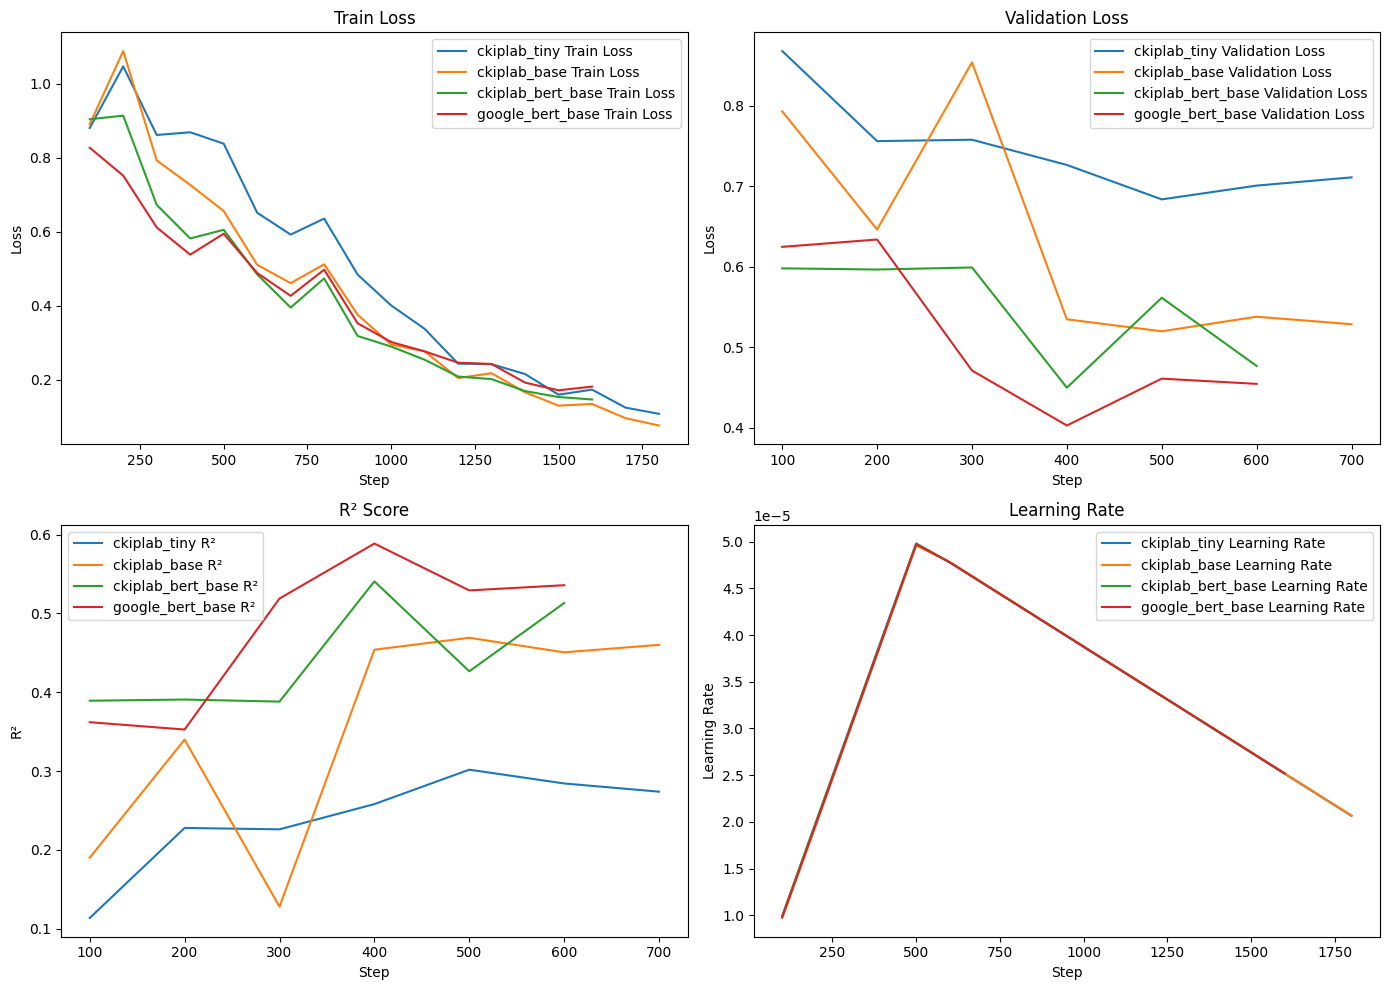

In [53]:
log_dirs = [
    './logs/ckiplab_tiny',
    './logs/ckiplab_base',
    './logs/ckiplab_bert_base',
    './logs/google_bert_base'
]

losses_train = {f'model_{i+1}': [] for i in range(4)}
losses_val = {f'model_{i+1}': [] for i in range(4)}
r2_scores = {f'model_{i+1}': [] for i in range(4)}
lrs = {f'model_{i+1}': [] for i in range(4)}
steps = {f'model_{i+1}': [] for i in range(4)}

for i, log_dir in enumerate(log_dirs):
    ea = event_accumulator.EventAccumulator(log_dir)
    ea.Reload()

    losses_train[f'model_{i+1}'] = [event.value for event in ea.Scalars('train/loss')]
    losses_val[f'model_{i+1}'] = [event.value for event in ea.Scalars('eval/loss')]
    r2_scores[f'model_{i+1}'] = [event.value for event in ea.Scalars('eval/r2')]
    lrs[f'model_{i+1}'] = [event.value for event in ea.Scalars('train/learning_rate')]
    steps[f'model_{i+1}'] = [event.step for event in ea.Scalars('train/loss')]

max_steps_length = max(len(steps[f'model_{i+1}']) for i in range(3))

for i in range(4):
    # 填充步數，使用 -1 作為填充值
    steps[f'model_{i+1}'] = np.pad(steps[f'model_{i+1}'], (0, max_steps_length - len(steps[f'model_{i+1}'])), mode='constant', constant_values=-1)
    # 填充損失，使用 np.nan 作為填充值
    losses_val[f'model_{i+1}'] = np.pad(losses_val[f'model_{i+1}'], (0, max_steps_length - len(losses_val[f'model_{i+1}'])), mode='constant', constant_values=np.nan)
    losses_train[f'model_{i+1}'] = np.pad(losses_train[f'model_{i+1}'], (0, max_steps_length - len(losses_train[f'model_{i+1}'])), mode='constant', constant_values=np.nan)
    r2_scores[f'model_{i+1}'] = np.pad(r2_scores[f'model_{i+1}'], (0, max_steps_length - len(r2_scores[f'model_{i+1}'])), mode='constant', constant_values=np.nan)
    lrs[f'model_{i+1}'] = np.pad(lrs[f'model_{i+1}'], (0, max_steps_length - len(lrs[f'model_{i+1}'])), mode='constant', constant_values=np.nan)

fig, axs = plt.subplots(2, 2, figsize=(14, 10))

model_names = [os.path.basename(log_dir) for log_dir in log_dirs]

for i in range(4):
    axs[0, 0].plot(steps[f'model_{i+1}'], losses_train[f'model_{i+1}'], label=f'{model_names[i]} Train Loss')
axs[0, 0].set_title('Train Loss')
axs[0, 0].set_xlabel('Step')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].legend()

for i in range(4):
    axs[0, 1].plot(steps[f'model_{i+1}'], losses_val[f'model_{i+1}'], label=f'{model_names[i]} Validation Loss')
axs[0, 1].set_title('Validation Loss')
axs[0, 1].set_xlabel('Step')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].legend()

for i in range(4):
    axs[1, 0].plot(steps[f'model_{i+1}'], r2_scores[f'model_{i+1}'], label=f'{model_names[i]} R²')
axs[1, 0].set_title('R² Score')
axs[1, 0].set_xlabel('Step')
axs[1, 0].set_ylabel('R²')
axs[1, 0].legend()

for i in range(4):
    axs[1, 1].plot(steps[f'model_{i+1}'], lrs[f'model_{i+1}'], label=f'{model_names[i]} Learning Rate')
axs[1, 1].set_title('Learning Rate')
axs[1, 1].set_xlabel('Step')
axs[1, 1].set_ylabel('Learning Rate')
axs[1, 1].legend()

plt.tight_layout()
plt.show()

### Summary:

**BERT vs ALBERT**: Among the four models, BERT-based models significantly outperform the ALBERT models, especially in terms of validation loss and R² scores. This indicates that BERT models are more capable and adaptable for this regression task compared to ALBERT.

**Overfitting**: Both the google_bert_base and ckiplab_bert_base models show signs of overfitting, with validation loss increasing after the 6th epoch, leading to early stopping. This suggests that further fine-tuning is needed to improve generalization and prevent overfitting.

**Need for Hyperparameter Tuning**: Hyperparameter tuning is crucial for improving model performance. As the current models show signs of overfitting despite early stopping.

